# Exploratory Data Analysis

In [72]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from datetime import datetime
import pandas as pd
import geopandas as gpd
from shapely.wkb import loads
import pytz

db_url = "postgresql://localhost:5432/analysis"

engine = create_engine(db_url)

session = sessionmaker(bind=engine)
session = session()

route_id = "39"
direction_id = 0
schedule_relationship = "SCHEDULED"
start_date = "2024-06-01"

query = f"SELECT * FROM gtfs_vehicleposition WHERE vehicle_trip_route_id='{route_id}' AND vehicle_trip_direction_id={direction_id} AND vehicle_trip_schedule_relationship='{schedule_relationship}' AND vehicle_trip_start_date='{start_date}';"

results = session.execute(query)

# Convert the results to a GeoPandas GeoDataFrame
gdf = gpd.GeoDataFrame(results, columns=results.keys())
gdf.sort_values(by="vehicle_timestamp", ascending=True)
gdf.drop(
    columns=[
        "id",
        "vehicle_trip_direction_id",
        "vehicle_trip_schedule_relationship",
        "vehicle_vehicle_license_plate",
        "vehicle_position_speed",
        "vehicle_trip_route_id",
        "vehicle_congestion_level",
        "vehicle_vehicle_wheelchair_accessible",
        "vehicle_position_longitude",
        "vehicle_position_latitude",
        "vehicle_position_odometer",
    ],
    inplace=True,
)
gdf["vehicle_position_point"] = gdf["vehicle_position_point"].apply(
    lambda x: loads(bytes.fromhex(x))
)
gdf["vehicle_trip_start_date"] = pd.to_datetime(gdf["vehicle_trip_start_date"])
gdf["vehicle_trip_start_timestamp"] = gdf["vehicle_trip_start_date"] + gdf["vehicle_trip_start_time"]
gdf["vehicle_trip_start_timestamp"] = gdf["vehicle_trip_start_timestamp"].dt.tz_localize(pytz.timezone("America/New_York"))
gdf["vehicle_timestamp"] = gdf["vehicle_timestamp"].dt.tz_convert(pytz.timezone("America/New_York"))
gdf["time_traveled"] = gdf["vehicle_timestamp"] - gdf["vehicle_trip_start_timestamp"]
gdf.sample(15)

,entity_id,vehicle_trip_trip_id,vehicle_vehicle_id,vehicle_trip_start_time,vehicle_trip_start_date,vehicle_vehicle_label,vehicle_position_point,vehicle_position_bearing,vehicle_current_stop_sequence,vehicle_current_status,vehicle_timestamp,vehicle_stop_id,vehicle_occupancy_percentage,vehicle_occupancy_status,feed_message_id,vehicle_trip_start_timestamp,time_traveled
6192,y1200,61885987,y1200,0 days 15:19:00,2024-06-01,1200,POINT (-71.08022 42.346546),0.0,4,IN_TRANSIT_TO,2024-06-01 15:29:07-04:00,11388,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717270190,2024-06-01 15:19:00-04:00,0 days 00:10:07
2215,y1266,61885949,y1266,0 days 09:06:00,2024-06-01,1266,POINT (-71.11163 42.319584),187.0,18,STOPPED_AT,2024-06-01 09:27:51-04:00,1160,20.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717248477,2024-06-01 09:06:00-04:00,0 days 00:21:51
7806,y1253,61885916,y1253,0 days 18:15:00,2024-06-01,1253,POINT (-71.065315 42.331486),0.0,1,STOPPED_AT,2024-06-01 18:00:23-04:00,23391,20.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717279228,2024-06-01 18:15:00-04:00,-1 days +23:45:23
4782,y1219,61885907,y1219,0 days 13:07:00,2024-06-01,1219,POINT (-71.10019 42.33618),228.0,9,STOPPED_AT,2024-06-01 13:27:40-04:00,91391,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717262863,2024-06-01 13:07:00-04:00,0 days 00:20:40
11387,y1263,61885969,y1263,0 days 23:45:00,2024-06-01,1263,POINT (-71.09116 42.339478),220.0,7,IN_TRANSIT_TO,2024-06-02 00:03:16-04:00,61391,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717301001,2024-06-01 23:45:00-04:00,0 days 00:18:16
3862,y1222,61885923,y1222,0 days 11:25:00,2024-06-01,1222,POINT (-71.11174 42.3195),195.0,18,IN_TRANSIT_TO,2024-06-01 12:10:32-04:00,1160,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717258236,2024-06-01 11:25:00-04:00,0 days 00:45:32
5066,y1218,61885882,y1218,0 days 13:58:00,2024-06-01,1218,POINT (-71.06299 42.3433),283.0,1,STOPPED_AT,2024-06-01 13:37:39-04:00,23391,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717263462,2024-06-01 13:58:00-04:00,-1 days +23:39:39
5183,y1219,61885907,y1219,0 days 13:07:00,2024-06-01,1219,POINT (-71.11423 42.31343),0.0,20,STOPPED_AT,2024-06-01 13:45:12-04:00,1164,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717263928,2024-06-01 13:07:00-04:00,0 days 00:38:12
6158,y1200,61885987,y1200,0 days 15:19:00,2024-06-01,1200,POINT (-71.07431 42.34737),0.0,1,STOPPED_AT,2024-06-01 15:15:34-04:00,23391,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717269349,2024-06-01 15:19:00-04:00,-1 days +23:56:34
9580,y1208,61885993,y1208,0 days 20:33:00,2024-06-01,1208,POINT (-71.0764 42.349457),0.0,3,STOPPED_AT,2024-06-01 20:40:42-04:00,178,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717288883,2024-06-01 20:33:00-04:00,0 days 00:07:42


In [39]:
# Load GTFS relevant tables

routes = pd.read_csv("GTFS/routes.csv")
stops = pd.read_csv("GTFS/stops.csv")
trips = pd.read_csv("GTFS/trips.csv")
shapes = pd.read_csv("GTFS/shapes.csv")

/var/folders/91/h3118x615zv1j98p7mf023hh0000gn/T/ipykernel_9531/1165028047.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv("GTFS/trips.csv")


In [42]:
trips_list = gdf["vehicle_trip_trip_id"].unique()
shapes_list = []
for trip_id in trips_list:
    shape_id = trips.loc[trips["trip_id"] == trip_id, "shape_id"].values[0]
    shapes_list.append(shape_id)
trip_shape = pd.DataFrame({"trip_id": trips_list, "shape_id": shapes_list})


In [91]:

# Count how many counts for each unique value in trip_shape["shape_id"]
shape_counts = trip_shape["shape_id"].value_counts()
# Get the trip_id for the shape_id 1920055
delete_trip = trip_shape.loc[trip_shape["shape_id"] == "1920055", "trip_id"].values[0]
# In gdf, delete the rows where vehicle_trip_trip_id is equal to delete_trip
gdf = gdf[gdf["vehicle_trip_trip_id"] != delete_trip]

In [92]:
from shapely.geometry import LineString

unique_shapes = trip_shape["shape_id"].unique()
geo_shapes = gpd.GeoDataFrame({"shape_id": [], "geometry": []})
for shape in unique_shapes:
    shape_points = shapes.loc[shapes["shape_id"] == shape]
    line = LineString(zip(shape_points["shape_pt_lon"], shape_points["shape_pt_lat"]))
    geo_shape = gpd.GeoDataFrame({"shape_id": [shape], "geometry": [line]})
    geo_shapes = pd.concat([geo_shapes, geo_shape], ignore_index=True)

In [93]:
geo_shapes

,shape_id,geometry
0,390152,"LINESTRING (-71.07454 42.34745, -71.07452 42.3..."
1,1920055,"LINESTRING (-71.05779 42.36181, -71.05795 42.3..."


<Axes: >

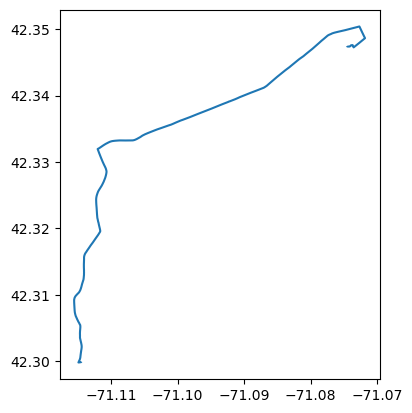

In [57]:
# Print a map shape_id 390152 in the GeoDataFrame geo_shapes
geo_shapes.loc[geo_shapes["shape_id"] == "390152"].plot()

In [94]:
from shapely.geometry import Point

point = Point(-71.114484, 42.299977)
line = geo_shapes.loc[geo_shapes["shape_id"] == "390152", "geometry"].values[0]


In [95]:
# In gdf, create a new column called "distance_traveled" that contains the distance between the vehicle_position_point and the shape_390152 LineString
gdf["distance_traveled"] = gdf.apply(lambda row: line.project(row["vehicle_position_point"]) * 111139, axis=1)

/Users/fabian/anaconda3/lib/python3.11/site-packages/shapely/linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


In [97]:
gdf.sample(15)


,entity_id,vehicle_trip_trip_id,vehicle_vehicle_id,vehicle_trip_start_time,vehicle_trip_start_date,vehicle_vehicle_label,vehicle_position_point,vehicle_position_bearing,vehicle_current_stop_sequence,vehicle_current_status,vehicle_timestamp,vehicle_stop_id,vehicle_occupancy_percentage,vehicle_occupancy_status,feed_message_id,vehicle_trip_start_timestamp,time_traveled,distance_traveled
11955,y1200,61885998,y1200,1 days 01:01:00,2024-06-01,1200,POINT (-71.08293 42.344597),229.0,5,IN_TRANSIT_TO,2024-06-02 01:47:23-04:00,31391,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717307246,2024-06-02 01:01:00-04:00,0 days 00:46:23,1949.720897
7073,y1216,61885959,y1216,0 days 16:50:00,2024-06-01,1216,POINT (-71.0763 42.348293),0.0,1,STOPPED_AT,2024-06-01 16:50:58-04:00,23391,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717275069,2024-06-01 16:50:00-04:00,0 days 00:00:58,1078.467368
3761,y1222,61885923,y1222,0 days 11:25:00,2024-06-01,1222,POINT (-71.110985 42.32776),195.0,15,IN_TRANSIT_TO,2024-06-01 12:07:45-04:00,31365,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717258070,2024-06-01 11:25:00-04:00,0 days 00:42:45,6033.674813
3035,y1216,61885975,y1216,0 days 10:51:00,2024-06-01,1216,POINT (-71.07459 42.34784),116.0,1,STOPPED_AT,2024-06-01 10:52:59-04:00,23391,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717253582,2024-06-01 10:51:00-04:00,0 days 00:01:59,0.000000
5367,y1200,61885985,y1200,0 days 13:41:00,2024-06-01,1200,POINT (-71.11233 42.324146),0.0,16,IN_TRANSIT_TO,2024-06-01 14:12:56-04:00,51365,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717265580,2024-06-01 13:41:00-04:00,0 days 00:31:56,6466.501194
9221,y1253,61885918,y1253,0 days 19:53:00,2024-06-01,1253,POINT (-71.111115 42.32943),0.0,14,STOPPED_AT,2024-06-01 20:17:32-04:00,22365,60.0,FEW_SEATS_AVAILABLE,MBTA-vehicle-1717287457,2024-06-01 19:53:00-04:00,0 days 00:24:32,5831.104646
10367,y1217,61885936,y1217,0 days 21:07:00,2024-06-01,1217,POINT (-71.11454 42.302143),0.0,26,IN_TRANSIT_TO,2024-06-01 22:06:30-04:00,10642,20.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717294049,2024-06-01 21:07:00-04:00,0 days 00:59:30,9066.271666
736,y1204,61885973,y1204,0 days 06:15:00,2024-06-01,1204,POINT (-71.11205 42.32138),166.0,18,IN_TRANSIT_TO,2024-06-01 06:43:14-04:00,1160,40.0,FEW_SEATS_AVAILABLE,MBTA-vehicle-1717238597,2024-06-01 06:15:00-04:00,0 days 00:28:14,6775.299572
1462,y1200,61885947,y1200,0 days 08:01:00,2024-06-01,1200,POINT (-71.07449 42.3476),270.0,1,STOPPED_AT,2024-06-01 07:58:43-04:00,23391,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717243147,2024-06-01 08:01:00-04:00,-1 days +23:57:43,0.000000
9593,y1208,61885993,y1208,0 days 20:33:00,2024-06-01,1208,POINT (-71.0765 42.34946),263.0,3,STOPPED_AT,2024-06-01 20:41:36-04:00,178,0.0,MANY_SEATS_AVAILABLE,MBTA-vehicle-1717288898,2024-06-01 20:33:00-04:00,0 days 00:08:36,1050.261723


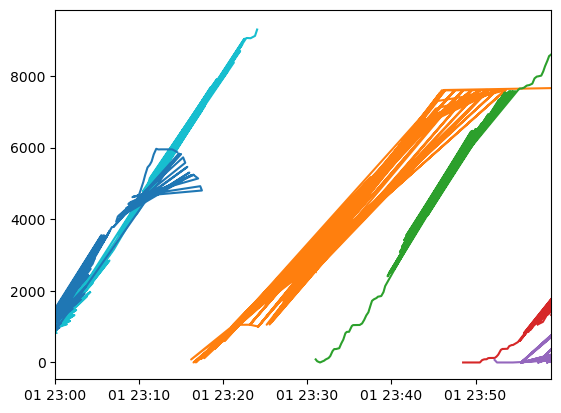

In [104]:
import matplotlib.pyplot as plt

for trip in trips_list:
    trip_data = gdf.loc[gdf["vehicle_trip_trip_id"] == trip]
    plt.plot(trip_data["vehicle_timestamp"], trip_data["distance_traveled"])

# In the x-axis, show the the plot from 2024-06-01 06:00:00 to 2024-06-01 07:00:00 in timezone America/New_York
plt.xlim(pd.Timestamp("2024-06-01 23:00:00").tz_localize("America/New_York"), pd.Timestamp("2024-06-01 23:59:00").tz_localize("America/New_York"))
plt.show()